In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import lal
import bilby
import bilby_ppe
MSUN_S  = lal.MSUN_SI * lal.G_SI / lal.C_SI ** 3

%load_ext autoreload
%autoreload 2

# ppE phase modification

This is implemented in `get_phi_ppe`.
ppE modifies the inpiral, and we continue the modification to merger and ringdown.

Below visualizes this function with a particular set of parameters.
Note that the transition is smooth at the inspiral cutoff. 

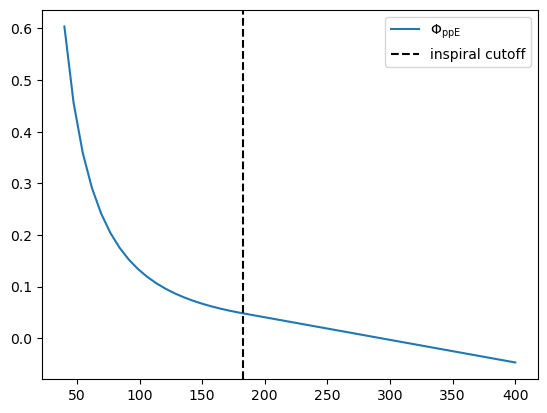

In [2]:
m1, m2 = 10., 10.
b, beta = -5, 1e-4
fcut_geom = 1.8e-2
fcut = fcut_geom / (m1 + m2) / MSUN_S

f = np.linspace(40, 400)
phi = bilby_ppe.get_phi_ppe(f, m1, m2, b, beta, fcut_geom=fcut_geom)
plt.plot(f, phi, label=r'$\Phi_\mathrm{ppE}$')
plt.axvline(fcut, linestyle='dashed', color='black', label='inspiral cutoff')
plt.legend()

# How to use it in bilby

The user only needs to modify the creation of `WaveformGenerator` in the typical bilby script. See the example below. Note that `lal_binary_black_hole_ppe` is used as the source model, and `ppe_inspiral_cutoff` is specified in waveform arguments. In the following, `IMRPhenomD` is chosen as the GR base WF.

In [3]:
duration = 32
sampling_frequency = 2048
reference_frequency = 20
minimum_frequency = 20

waveform_arguments = dict(waveform_approximant='IMRPhenomD',
                          ppe_inspiral_cutoff=1.8e-2,
                          reference_frequency=reference_frequency, 
                          minimum_frequency=minimum_frequency)
waveform_generator_ppe = bilby.gw.WaveformGenerator(
    duration=duration, 
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby_ppe.lal_binary_black_hole_ppe,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

22:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby_ppe.model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Let us verify the behavior of this waveform generator. We create another waveform generator in GR, and see if the difference reproduces the ppE modification plot above.

22:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


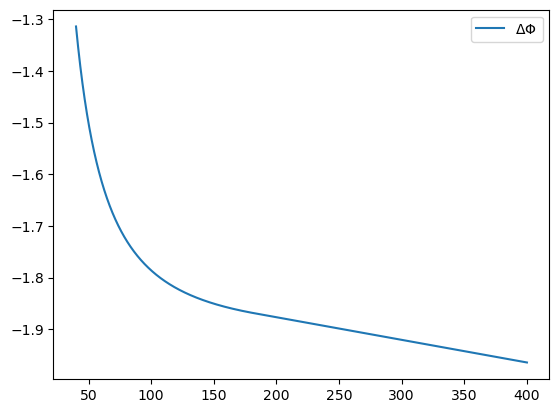

In [4]:
waveform_generator_gr = bilby.gw.WaveformGenerator(
    duration=duration, 
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

injection_parameters = dict(
    # same masses and ppE params as in the previous section
    mass_1=10.,
    mass_2=10.,
    chi_1=0.,
    chi_2=0.,
    psi=0., 
    phase=0., 
    ra=0., 
    dec=0.,
    theta_jn=0.4, 
    luminosity_distance=400.,
    geocent_time=1126259462.4, 
    b=-5,
    beta=1e-4,
)

waveform_generator_ppe.parameters = injection_parameters
waveform_generator_gr.parameters = injection_parameters
h_ppe = waveform_generator_ppe.frequency_domain_strain()
h_gr = waveform_generator_gr.frequency_domain_strain()
f = waveform_generator_ppe.frequency_array
mask = (f > 40) & (f < 400)

phase_diff = -np.unwrap(np.angle(h_ppe['plus'][mask] / h_gr['plus'][mask]))
plt.plot(f[mask], phase_diff, label=r'$\Delta\Phi$')
plt.legend()

This is essentially the same as what's presented in the previous plot. The curve is shifted in the y-direction, but the physics is the same. The shift is just a consequence of forcing the phase to be zero at the given reference frequency. 